In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patheffects
import matplotlib as mpl
import numpy as np
import pandas as pd
import vice

from surp import subgiants
import seaborn as sns
import surp

from surp import AGB_MODELS
import arya
import scipy
from scipy.stats import binned_statistic, norm

/astro/dboyea/.local/lib/python3.11/site-packages/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


# Main Figure

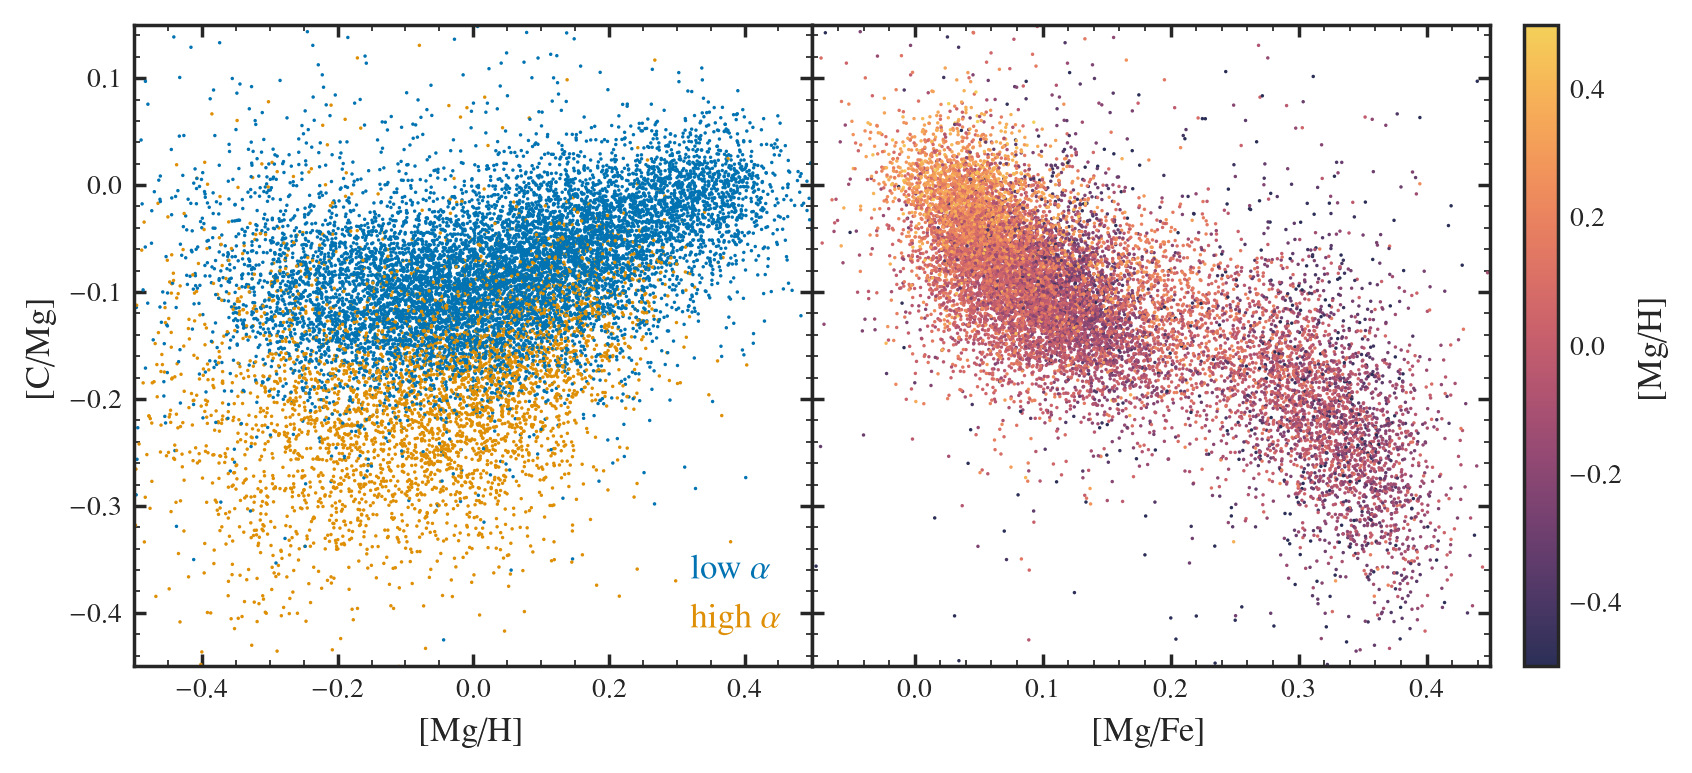

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(7, 10/3), sharey=True, gridspec_kw={"wspace": 0}, dpi=250)


kwargs = dict(
    rasterized=True, ec="none", s=1
)

plt.sca(axs[0])
sns.scatterplot(subgiants, x="MG_H", y="C_MG", hue="high_alpha", **kwargs)
L = arya.Legend(labels=[r"low $\alpha$", r"high $\alpha$"], color_only=True, loc=4)
for text in L.mpl_leg.get_texts():
    text.set_path_effects([mpl.patheffects.Stroke(linewidth=3, foreground='w'),
                       mpl.patheffects.Normal()])
    
plt.ylabel("[C/Mg]")
plt.xlabel("[Mg/H]")
plt.xlim(-0.5, 0.5)
plt.ylim(-0.45, 0.15)

plt.sca(axs[1])
sns.scatterplot(subgiants, x="MG_FE", y="C_MG", hue="MG_H", hue_norm=(-0.5, 0.5), legend=False,  palette=plt.get_cmap(), **kwargs)
plt.xlim(-0.08, 0.45)

plt.xlabel("[Mg/Fe]")

cax = axs[1].inset_axes([1.05, 0., 0.05, 1])

arya.Colorbar(clim=(-0.5, 0.5), label="[Mg/H]", cax=cax)
plt.savefig("figures/subgiants.pdf")

In [4]:
print(len(subgiants))

14066


# Binned visualization

In [3]:
def cooh_data(ax=None, **params):
    
    ha = subgiants["high_alpha"]
    df = subgiants[~ha]
    
    arya.binnedplot(df, x="MG_H", y="C_MG", binrange=(-0.5, 0.5), binwidth=0.05,
                              cmin=1, stat="median", errorbar="pi",   **params)
    
def coofe_data(o_0=-0.1, w=0.05, ax=None, **kwargs):

        
    filt = subgiants["MG_H"] > o_0 - w
    filt &= subgiants["MG_H"] < o_0 + w
    df = subgiants[filt]
    arya.binnedplot(df, x="MG_FE", y="C_MG", binrange=(-0.1, 0.5),
                              cmin=1, stat="median", errorbar="pi",   **params)

In [45]:
def finite_gaussian_kde(x, y, x_err, y_err, xlims=None, ylims=None, grid_size=100, cutoff=5):
    """
    Compute a 2D KDE using a finite Gaussian kernel.

    Parameters:
    - x, y: Arrays of data point coordinates.
    - x_uncertainties, y_uncertainties: Arrays of standard deviations for the Gaussian kernels.
    - grid_size: The number of points in each dimension for the grid.
    - cutoff: The cutoff in standard deviations for the finite Gaussian kernel.
    """
    # Define the grid
    if xlims is None:
        x_min, x_max = x.min() - cutoff * x_uncertainties.max(), x.max() + cutoff * x_uncertainties.max()
    else:
        x_min, x_max = xlims
        
    if ylims is None:
        y_min, y_max = y.min() - cutoff * y_uncertainties.max(), y.max() + cutoff * y_uncertainties.max()
    else:
        y_min, y_max = ylims
        
    x_grid = np.linspace(x_min, x_max, grid_size)
    y_grid = np.linspace(y_min, y_max, grid_size)
    x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

    # Initialize the KDE grid
    kde = np.zeros_like(x_mesh)

    # Vectorized computation of the finite Gaussian kernel
    for xi, yi, x_ui, y_ui in zip(x, y, x_err, y_err):
        # Determine the range affected by this point's kernel
        x_range = np.logical_and(x_grid >= xi - cutoff * x_ui, x_grid <= xi + cutoff * x_ui)
        y_range = np.logical_and(y_grid >= yi - cutoff * y_ui, y_grid <= yi + cutoff * y_ui)

        # Compute the kernel only within the cutoff range
        x_kernel = np.exp(-0.5 * ((x_grid[x_range] - xi) / x_ui) ** 2) / (x_ui * np.sqrt(2 * np.pi))
        y_kernel = np.exp(-0.5 * ((y_grid[y_range] - yi) / y_ui) ** 2) / (y_ui * np.sqrt(2 * np.pi))

        # Update the KDE grid
        kde[np.ix_(y_range, x_range)] += np.outer(y_kernel, x_kernel)

    return x_mesh, y_mesh, kde

In [79]:
x = subgiants.MG_H.values
y = subgiants.C_MG.values
x_err = subgiants.MG_H_ERR.values
y_err = subgiants.C_MG_ERR.values
percens = np.linspace(0, 100, 10)
bins = np.percentile(x, percens)
weights = 1/subgiants.C_MG_ERR**2

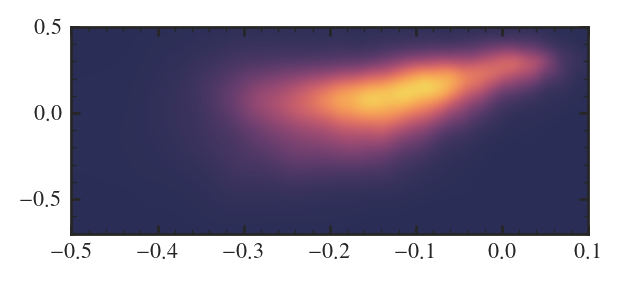

In [80]:
filt = np.full(x.shape, True)

x_grid, y_grid, kde = finite_gaussian_kde(x[filt], y[filt], x_err[filt], y_err[filt], ylims=(-0.5, 0.1), xlims=(-0.7, 0.5), grid_size=1024)
plt.imshow(kde, origin="lower", extent=[-0.5, 0.1, -0.7, 0.5], aspect=0.2)

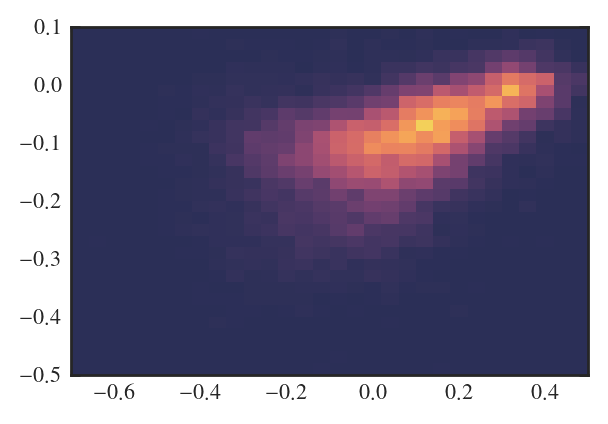

In [83]:
plt.hist2d(x, y, 30,  range=([-0.7, 0.5], [-0.5, 0.1]), weights=weights);

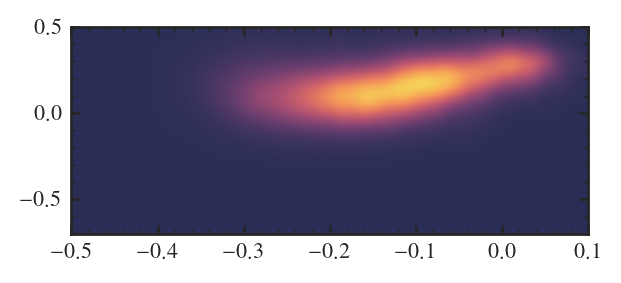

In [85]:
filt = ~subgiants.high_alpha

x_grid, y_grid, kde = finite_gaussian_kde(x[filt], y[filt], x_err[filt], y_err[filt], ylims=(-0.5, 0.1), xlims=(-0.7, 0.5), grid_size=1024)
plt.imshow(kde, origin="lower", extent=[-0.5, 0.1, -0.7, 0.5], aspect=0.2)

In [96]:
import json

In [104]:
np.save("kde_lowa.npy", kde)
with open("kde_lowa.json", "w") as f:
    json.dump({"N": 1024}, f)
    json.dump({"extent": [x_grid[0,0], x_grid[-1,-1], y_grid[0,0], y_grid[-1,-1]]}, f)

In [ ]:
plt.plot(x_grid[0, :], np.sum(kde * y_grid, axis=0) / np.sum(kde, axis=0))
plt.contourf(x_grid, y_grid, kde, cmap="Greys")
arya.medianplot(subgiants[~subgiants.high_alpha], "MG_H", "C_MG", binsize=1000)

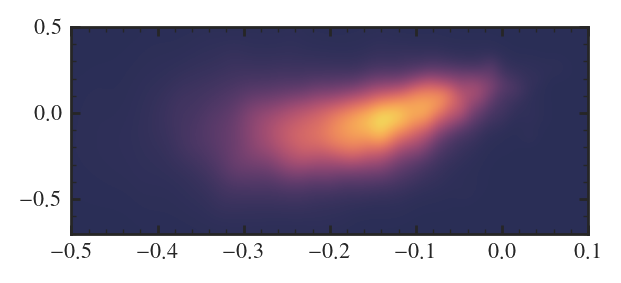

In [56]:
filt = subgiants.high_alpha

x_grid, y_grid, kde = finite_gaussian_kde(x[filt], y[filt], x_err[filt], y_err[filt], ylims=(-0.5, 0.1), xlims=(-0.7, 0.5), grid_size=300)
plt.imshow(kde, origin="lower", extent=[-0.5, 0.1, -0.7, 0.5], aspect=0.2)

In [58]:

x = subgiants.MG_FE
x_err = subgiants.MG_FE_ERR

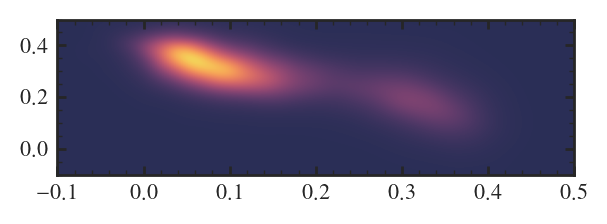

In [65]:
filt = surp

x_grid, y_grid, kde = finite_gaussian_kde(x[filt], y[filt], x_err[filt], y_err[filt], ylims=(-0.5, 0.1), xlims=(-0.1, 0.5), grid_size=300)


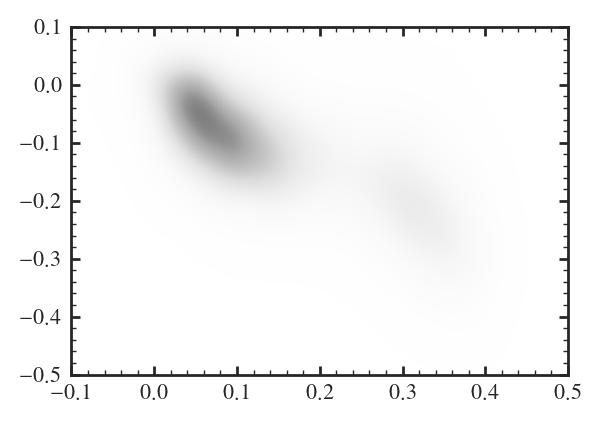

In [77]:
plt.imshow(kde, origin="lower", extent=[-0.1, 0.5, -0.5, 0.1], aspect=0.7, cmap="Greys", alpha=0.5)

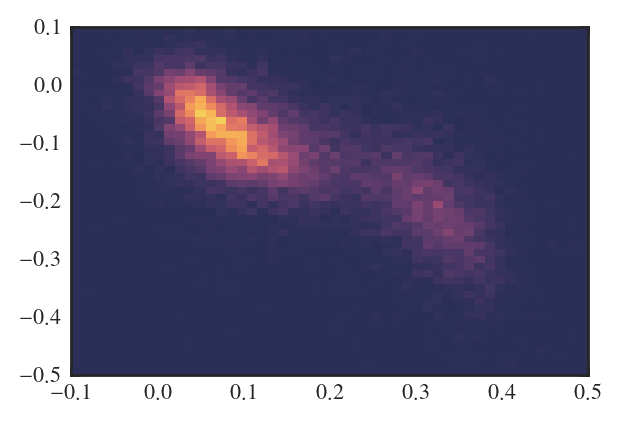

In [69]:
plt.hist2d(x, y,50,  range=([-0.1, 0.5], [-0.5, 0.1]));

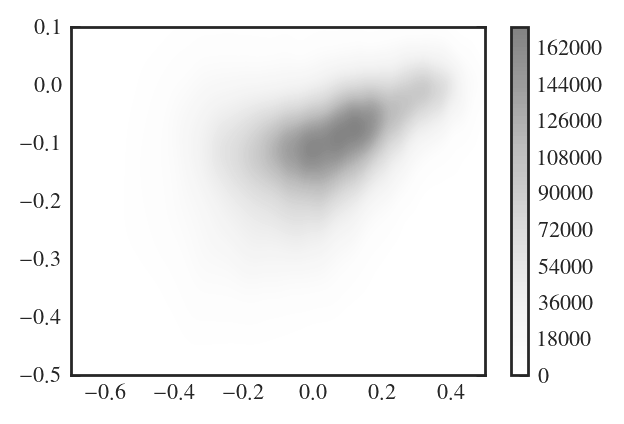

In [44]:
plt.contourf(x_grid, y_grid, kde, levels=100, cmap="Greys", vmax=3e5)
plt.colorbar()

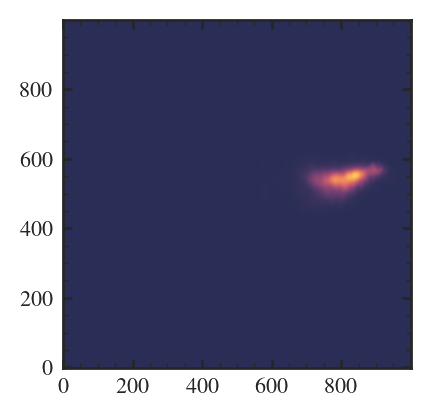

In [7]:
plt.imshow(kde, origin="lower")

In [ ]:
plt.contourf(x_grid, y_grid, kde)

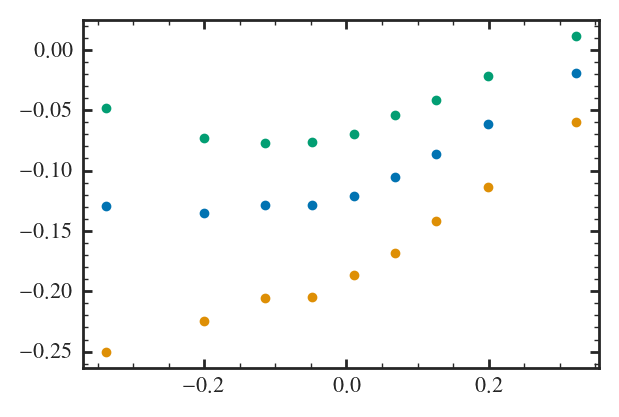

In [58]:
plt.scatter(xs, ys)
plt.scatter(xs, yl)
plt.scatter(xs, yh)

In [42]:
x0 = -0.5
w = 0.05
f = x0-w < x 
f &= x < x0 + w

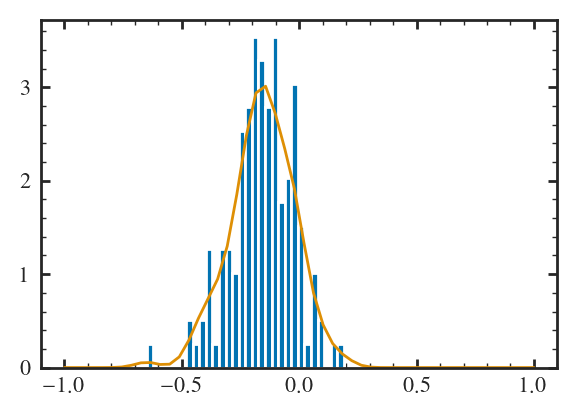

In [43]:
kernel = scipy.stats.gaussian_kde(y[f])
plt.hist(y[f], 30, density=True)
x_pred = np.linspace(-1, 1)
plt.plot(x_pred, kernel(x_pred))

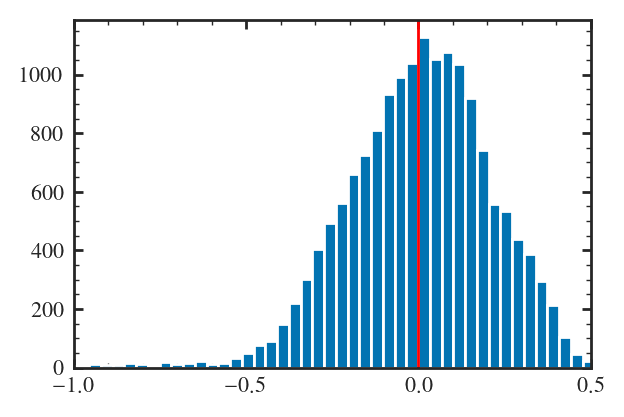

In [10]:
plt.hist(surp.subgiants.MG_H, 100);
plt.xlim(-1, 0.5)
plt.axvline(0.0, color="r")

## Median binning 

In [ ]:
bins = 

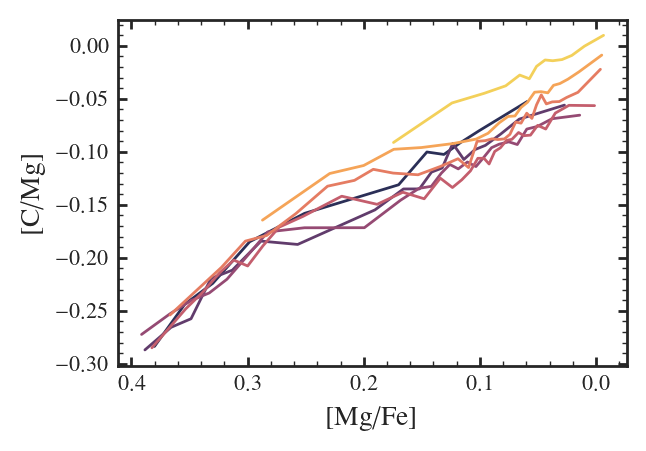

In [5]:
fig, ax = plt.subplots(figsize=(10/3, 10/3/2**0.5))

cb = arya.HueMap( clim=(-0.3, 0.3))

for MH in (-0.3, -0.2,-0.1,0, 0.1, 0.2,0.3):
    mh0 = MH - 0.05
    mh1 = MH + 0.05
    filt = subgiants.MG_H > mh0
    filt &= subgiants.MG_H < mh1
    df = subgiants[filt]
    
    arya.medianplot(df, x="MG_FE", y="C_MG", binsize=100, color=cb(MH), aes="line", errorbar=None)

plt.gca().invert_xaxis()

plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")

plt.tight_layout()
plt.savefig("figures/apogee_caafe_binned.pdf")

(-0.5, 0.5)

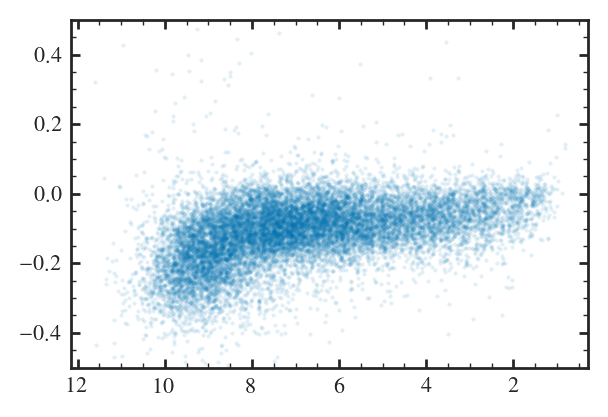

In [6]:
plt.scatter(subgiants.age, subgiants.C_MG, s=0.3, alpha=0.1)
plt.gca().invert_xaxis()
plt.ylim(-0.5, 0.5)


#